In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR100(root='./data/CIFAR100', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 169001437/169001437 [00:01<00:00, 93274109.38it/s] 


Extracting ./data/CIFAR100/cifar-100-python.tar.gz to ./data/CIFAR100


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsampling=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsampling = downsampling
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential()
        if downsampling:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampling:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block=ResidualBlock, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, blocks=3, stride=1)
        self.layer2 = self.make_layer(block, 128, blocks=4, stride=2)
        self.layer3 = self.make_layer(block, 256, blocks=6, stride=2)
        self.layer4 = self.make_layer(block, 512, blocks=3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsampling=True))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net0 = ResNet().to(device)
net = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

In [ ]:
def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = len(trainloader)
    for image, label in islice(trainloader, size):
        image, label = image.to(device), label.to(device)
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()
    return 100 * correct / len(trainset)

def train(name):
    xs, ys = [], []
    batch_num = len(trainloader)
    for epoch in range(10):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, batch_num):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        xs.append(epoch + 1)
        ys.append(running_loss / len(trainset))
        print(f'Эпоха: {xs[-1]}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = name)
    return xs, ys

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")

Точность без обучения: 1.15%


Эпоха: 1, Потери: 0.05850447107791901
Эпоха: 2, Потери: 0.04491593942642212
Эпоха: 3, Потери: 0.03540725235939026
Эпоха: 4, Потери: 0.02855566696166992
Эпоха: 5, Потери: 0.022983657068014144
Эпоха: 6, Потери: 0.01885669098496437
Эпоха: 7, Потери: 0.013988096089363099
Эпоха: 8, Потери: 0.009452163705825805
Эпоха: 9, Потери: 0.005993057577610016
Эпоха: 10, Потери: 0.003446270187497139
Точность после обучения: 93.58%


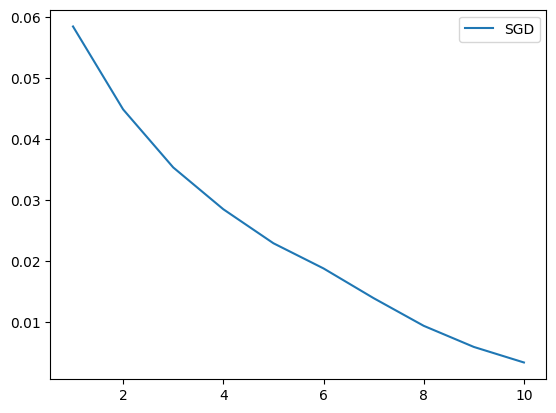

In [ ]:
resetNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
xs1, ys1 = train("SGD")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.053419584765434264
Эпоха: 2, Потери: 0.037944278609752656
Эпоха: 3, Потери: 0.02949137298345566
Эпоха: 4, Потери: 0.02366854092121124
Эпоха: 5, Потери: 0.01878330817937851
Эпоха: 6, Потери: 0.014524789131879807
Эпоха: 7, Потери: 0.01061492928802967
Эпоха: 8, Потери: 0.007147007113397121
Эпоха: 9, Потери: 0.004634461637437344
Эпоха: 10, Потери: 0.0029280887477844955
Точность после обучения: 95.61%


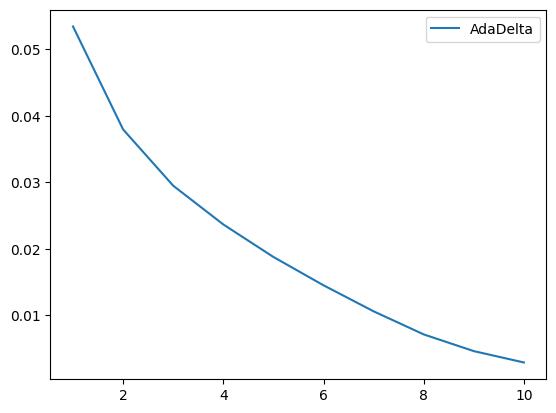

In [13]:
resetNet()
optimizer = optim.Adadelta(net.parameters(), lr=0.1)
xs2, ys2 = train("AdaDelta")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.05556274215221405
Эпоха: 2, Потери: 0.04060275281429291
Эпоха: 3, Потери: 0.03162339178085327
Эпоха: 4, Потери: 0.0255319864821434
Эпоха: 5, Потери: 0.020401133290529252
Эпоха: 6, Потери: 0.015781275606155394
Эпоха: 7, Потери: 0.011622920771241187
Эпоха: 8, Потери: 0.00786557601928711
Эпоха: 9, Потери: 0.005252404782921076
Эпоха: 10, Потери: 0.003418180813714862
Точность после обучения: 95.82%


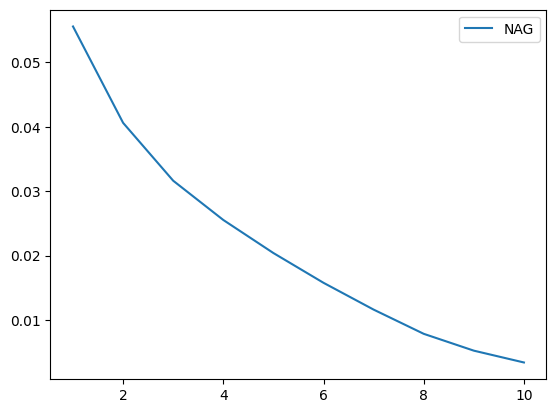

In [15]:
resetNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
xs3, ys3 = train("NAG")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

Эпоха: 1, Потери: 0.06035246423721313
Эпоха: 2, Потери: 0.04696288589477539
Эпоха: 3, Потери: 0.03715049879074097
Эпоха: 4, Потери: 0.030147279698848724
Эпоха: 5, Потери: 0.02482022247314453
Эпоха: 6, Потери: 0.020014322744607925
Эпоха: 7, Потери: 0.015037088071107865
Эпоха: 8, Потери: 0.010373737216889858
Эпоха: 9, Потери: 0.00667096855789423
Эпоха: 10, Потери: 0.004565099024772644
Точность после обучения: 94.79%


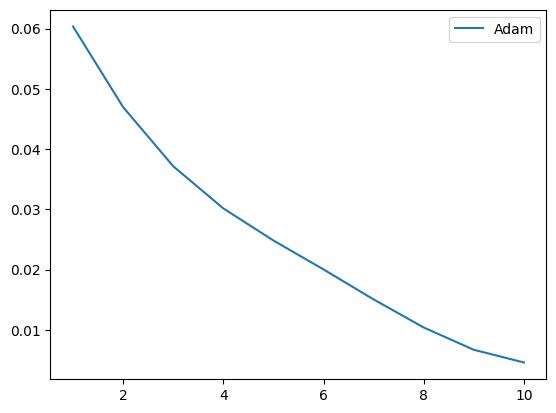

In [17]:
resetNet()
optimizer = optim.Adam(net.parameters(), lr=0.001)
xs4, ys4 = train("Adam")
print(f"Точность после обучения: {countAccuracy():.2f}%")
plt.legend()
plt.show()

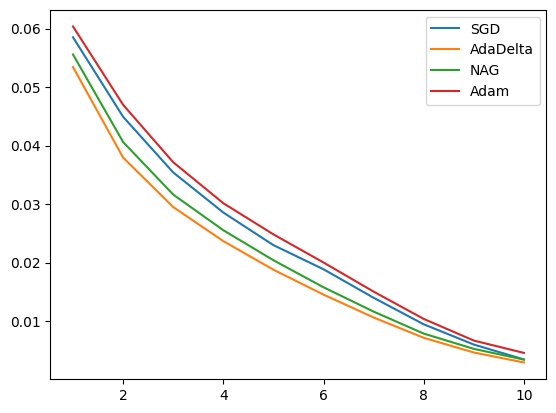

In [19]:
plt.plot(xs1, ys1, label = "SGD")
plt.plot(xs2, ys2, label = "AdaDelta")
plt.plot(xs3, ys3, label = "NAG")
plt.plot(xs4, ys4, label = "Adam")
plt.legend()
plt.show()